In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

image: (512, 512)   min: 0.0   max: 0.949019607843
kernel: (32, 32)   min: 0.0   max: 0.0627450980392


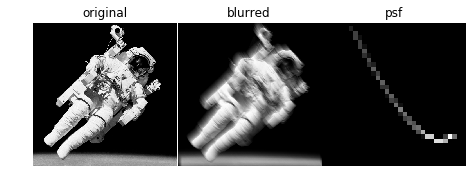

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, color
from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration
from pprint import pprint

def showPics(pics, cols=2):
    plt.gray()
    plt.rcParams["figure.figsize"] = 16, 16
    n= len(pics)

    rows= int((n+1)/cols)

    r= 1
    c= 1
    i= 1
    
    for pic in pics:
        if (c>cols):
            c= 0
            r+= 1
        
        plt.subplot(rows, cols, i)
        plt.imshow(pic[0])
        plt.title(pic[1])
        
        i+= 1
        c+= 1
        plt.axis('off')
            
    plt.gray()
    plt.subplots_adjust(wspace=0.01, hspace=0.1, top=1, bottom=0, left=0, right=1)
    plt.show()    
    
    return


original= io.imread('scaled.png')
blurred= io.imread('blurred.png')/255
kernel= np.load("swirl.npy")

print ("image:" , blurred.shape , "  min:" , np.min(blurred), "  max:" , np.max(blurred))
print ("kernel:" , kernel.shape , "  min:" , np.min(kernel), "  max:" , np.max(kernel))

showPics([
    [original, "original"], 
    [blurred, "blurred"],
    [kernel, "psf"]],3)


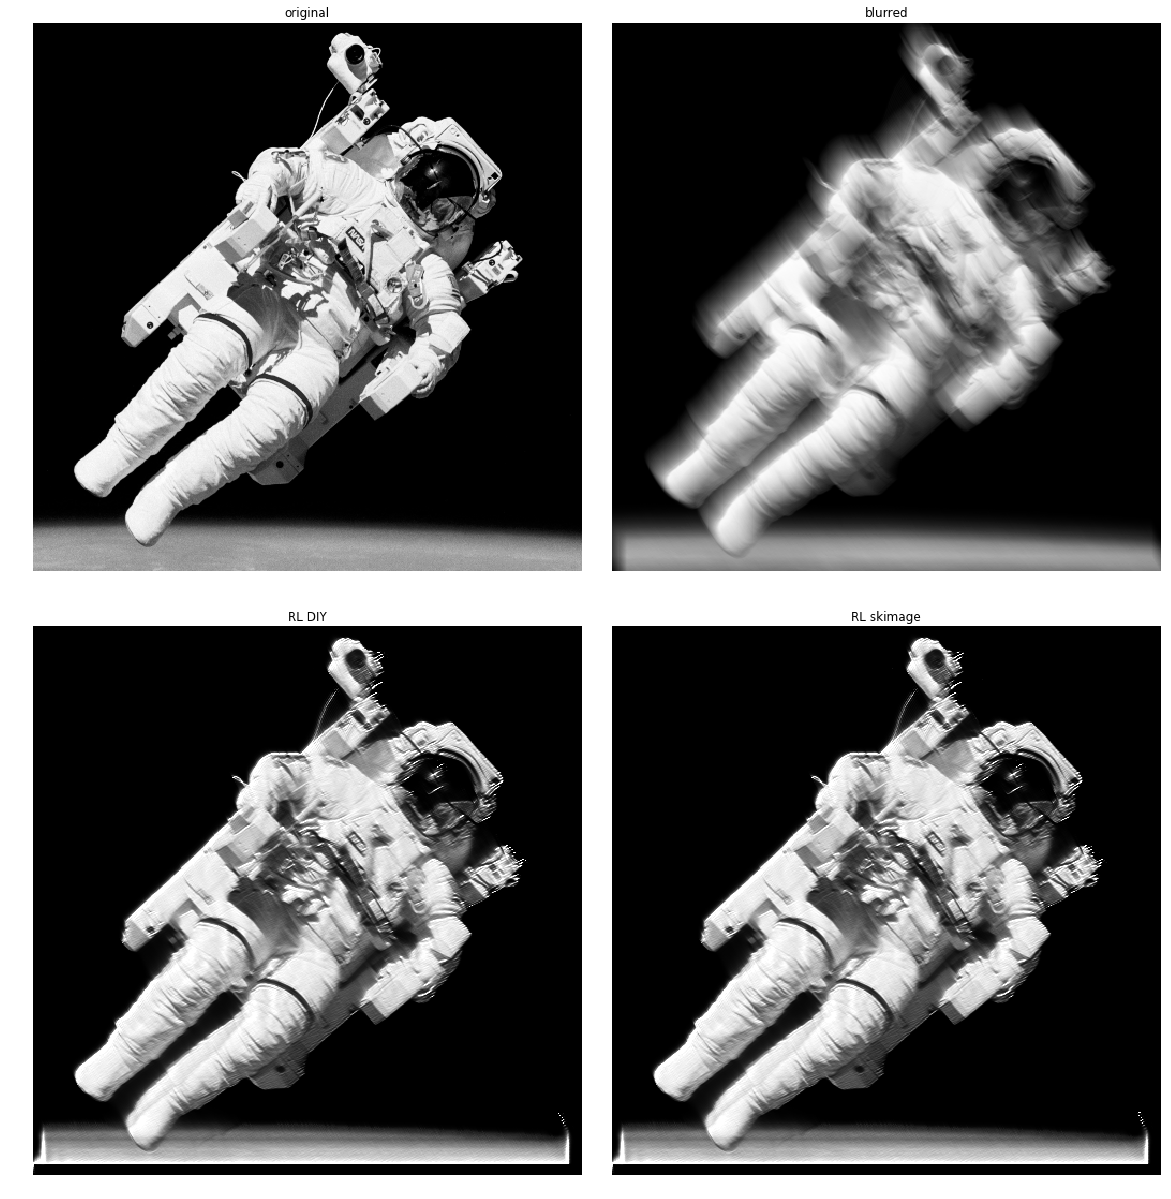

In [3]:
import scipy
epsilon= np.finfo("float64").eps

def RL_deconv(image, psf, iterations):
   
#    latent= image.copy()
    latent= 0.5*np.ones(image.shape)

    fsp= psf[::-1, ::-1]
    
    for i in range(iterations):
        
        est_conv      = scipy.signal.convolve2d(latent, psf, 'same')
        est_conv[est_conv == 0] = epsilon  # avoid div by zero
        relative_blur = np.divide(image, est_conv)
        error     = scipy.signal.convolve2d(relative_blur,fsp,'same') 
        latent    = np.multiply(latent, error) 
    return latent

runs=30

inp= blurred+epsilon

deco= RL_deconv(blurred, kernel, runs)
deco[deco > 1] = 1-epsilon
deco[deco < -1] = 0

decoSK = restoration.richardson_lucy(blurred+0.00001, kernel, iterations= runs)
decoSK[decoSK > 1] = 1-epsilon
decoSK[decoSK < -1] = 0

showPics([ 
    [original, "original"], 
    [blurred, "blurred"],
    [deco, "RL DIY"],
    [decoSK, "RL skimage"]
])